In [1]:
import pandas as pd
import requests

# Baixar os dados do link
url = "https://n8n.coinverge.com.br/webhook/precos"
response = requests.get(url)
data = response.json()

# Converter para DataFrame
df = pd.DataFrame(data)

# Exemplo de conversão de tipos de dados
# Ajuste conforme os tipos reais dos dados
for col in df.columns:
    # Tenta converter para numérico, se possível
    df[col] = pd.to_numeric(df[col], errors='ignore')

# Exibe os tipos de dados convertidos
print(df.dtypes)
df.head()

id                                     int64
simbolo                               object
ultimo_preco                         float64
preco_maximo                         float64
preco_minimo                         float64
preco_abertura                       float64
datahora_fechamento                   object
variacao_preco_percentual            float64
cenario                               object
variacao_futura_de_preco_positiva    float64
variacao_futura_de_preco_negativa    float64
variacao_futura_de_preco             float64
variacao_futura_de_preco_binaria     float64
preco_anterior                       float64
dtype: object


C:\Users\cassi\AppData\Local\Temp\ipykernel_1616\2859750278.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


,id,simbolo,ultimo_preco,preco_maximo,preco_minimo,preco_abertura,datahora_fechamento,variacao_preco_percentual,cenario,variacao_futura_de_preco_positiva,variacao_futura_de_preco_negativa,variacao_futura_de_preco,variacao_futura_de_preco_binaria,preco_anterior
0,229216,1INCHUSDT,0.2903,0.295,0.2824,0.2849,2025-07-28T13:00:34.000Z,1.895,---,NaN,-0.620048,-0.620048,0.0,NaN
1,229497,1INCHUSDT,0.2885,0.295,0.2824,0.2904,2025-07-28T14:00:53.000Z,-0.654,---,NaN,-0.381282,-0.381282,0.0,NaN
2,229784,1INCHUSDT,0.2874,0.295,0.2824,0.2866,2025-07-28T15:00:51.000Z,0.279,---,NaN,-0.695894,-0.695894,0.0,NaN
3,230065,1INCHUSDT,0.2854,0.295,0.2824,0.2871,2025-07-28T16:00:53.000Z,-0.592,---,NaN,-1.331465,-1.331465,0.0,NaN
4,230349,1INCHUSDT,0.2816,0.295,0.2800,0.2858,2025-07-28T17:00:55.000Z,-1.470,---,NaN,-1.775568,-1.775568,0.0,NaN


In [ ]:
# Classe de backtest com stop dinâmico e campos vazios na primeira linha de cada ativo
class BacktestStopDinamico:
    def __init__(self, df):
        self.df = df.copy()
        self.resultados = {}

    def simular(self):
        for simbolo, grupo in self.df.groupby('simbolo'):
            grupo = grupo.sort_values('datahora_fechamento').copy()
            grupo['stop'] = np.nan
            grupo['retorno_estrategia'] = np.nan
            grupo['acumulado_estrategia'] = np.nan
            grupo['variacao_acumulado_max_desceu'] = np.nan

            prev_stop = None
            prev_acumulado = 1
            max_acumulado = 1
            stop_vals = []
            retorno_estrategia = []
            acumulado = []
            variacao_max_desceu = []

            for i in range(len(grupo)):
                if i == 0:
                    # Primeira linha: campos vazios
                    stop_vals.append(np.nan)
                    retorno_estrategia.append(np.nan)
                    acumulado.append(np.nan)
                    variacao_max_desceu.append(np.nan)
                    continue

                fechamento = grupo.iloc[i]['ultimo_preco']
                minimo = grupo.iloc[i]['preco_minimo']
                abertura = grupo.iloc[i]['preco_abertura']

                prev_fechamento = grupo.iloc[i-1]['ultimo_preco']
                prev_minimo = grupo.iloc[i-1]['preco_minimo']
                prev_stop = (prev_fechamento - prev_minimo) / prev_fechamento
                stop_vals.append(prev_stop)

                stop_preco = abertura * (1 - prev_stop)
                if minimo <= stop_preco:
                    retorno = (stop_preco - abertura) / abertura
                else:
                    retorno = (fechamento - abertura) / abertura

                retorno_estrategia.append(retorno)
                prev_acumulado *= (1 + retorno)
                acumulado.append(prev_acumulado)
                max_acumulado = max(max_acumulado, prev_acumulado)
                variacao_max_desceu.append((prev_acumulado - max_acumulado) / max_acumulado)

            grupo['stop'] = stop_vals
            grupo['retorno_estrategia'] = retorno_estrategia
            grupo['acumulado_estrategia'] = acumulado
            grupo['variacao_acumulado_max_desceu'] = variacao_max_desceu

            self.resultados[simbolo] = grupo

    def plot_tabelas(self):
        i=0
        for simbolo, resultado in self.resultados.items():  # Limitar a plotar apenas os 2 primeiros ativos
            i=i+1
            if i<2:
                print(f"Tabela de resultados para {simbolo}:")
                # print(f"Tabela de resultados para {simbolo}:")
                # display(resultado[['datahora_fechamento', 'preco_abertura', 'ultimo_preco', 'preco_minimo', 'stop', 'retorno_estrategia', 'acumulado_estrategia', 'variacao_acumulado_max_desceu']].head(20))
                resultado[['acumulado_estrategia']].plot(title=f'Resultados para {simbolo}')
# Exemplo de uso:
backtest = BacktestStopDinamico(df)
backtest.simular()
backtest.plot_tabelas()

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display  # Para display em Jupyter

class BacktestStopDinamico:
    def __init__(self, df):
        self.df = df.copy()
        self.resultados = {}

    def simular(self):
        for simbolo, grupo in self.df.groupby('simbolo'):
            if len(grupo) < 24:
                continue  # Remove ativos com menos de 24 registros
            
            grupo = grupo.sort_values('datahora_fechamento').copy()
            grupo['stop'] = np.nan
            grupo['retorno_estrategia'] = np.nan
            grupo['acumulado_estrategia'] = np.nan
            grupo['variacao_acumulado_max_desceu'] = np.nan

            prev_stop = None
            prev_acumulado = 1
            max_acumulado = 1
            stop_vals = []
            retorno_estrategia = []
            acumulado = []
            variacao_max_desceu = []

            for i in range(len(grupo)):
                if i == 0:
                    # Primeira linha: campos vazios
                    stop_vals.append(np.nan)
                    retorno_estrategia.append(np.nan)
                    acumulado.append(np.nan)
                    variacao_max_desceu.append(np.nan)
                    continue

                fechamento = grupo.iloc[i]['ultimo_preco']
                minimo = grupo.iloc[i]['preco_minimo']
                abertura = grupo.iloc[i]['preco_abertura']

                prev_fechamento = grupo.iloc[i-1]['ultimo_preco']
                prev_minimo = grupo.iloc[i-1]['preco_minimo']
                prev_stop = (prev_fechamento - prev_minimo) / prev_fechamento # ISSO ESTA ERRADO
                stop_vals.append(prev_stop)

                stop_preco = abertura * (1 - prev_stop)
                if minimo <= stop_preco:
                    retorno = (stop_preco - abertura) / abertura
                else:
                    retorno = (fechamento - abertura) / abertura

                retorno_estrategia.append(retorno)
                prev_acumulado *= (1 + retorno)
                acumulado.append(prev_acumulado)
                max_acumulado = max(max_acumulado, prev_acumulado)
                variacao_max_desceu.append((prev_acumulado - max_acumulado) / max_acumulado)

            grupo['stop'] = stop_vals
            grupo['retorno_estrategia'] = retorno_estrategia
            grupo['acumulado_estrategia'] = acumulado
            grupo['variacao_acumulado_max_desceu'] = variacao_max_desceu

            self.resultados[simbolo] = grupo
            grupo.to_excel(f'resultados_{simbolo}.xlsx', index=False)  # Salvar resultados em Excel

    def plot_tabelas(self):
        # Limitar o número de ativos plotados para evitar sobrecarga de desempenho (ex: primeiros 5)
        simbolos_para_plotar = list(self.resultados.keys())  # Ajuste o número conforme necessário
        i=0
        for simbolo in self.resultados.keys():
            if i < 5:  # Limitar a plotar apenas os 2 primeiros
                i=i+1
                resultado = self.resultados[simbolo]
                # print(f"Tabela de resultados para {simbolo}:")
                print(f"Tabela de resultados para {simbolo}:")
                # display(resultado[['datahora_fechamento', 'preco_abertura', 'ultimo_preco', 'preco_minimo', 'stop', 'retorno_estrategia', 'acumulado_estrategia', 'variacao_acumulado_max_desceu']].head(20))
                
                # Plotar gráfico da variação do stop por ativo, mas apenas se for um dos selecionados e com poucos registros (ex: head(50))
                if simbolo in simbolos_para_plotar:
                    df_plot = resultado.head(50)  # Limitar a 50 registros para desempenho
                    plt.figure(figsize=(10, 6))
                    plt.plot(df_plot['datahora_fechamento'], df_plot['acumulado_estrategia'], marker='o', linestyle='-', color='b')
                    plt.title(f'Variação do Stop para {simbolo}')
                    plt.xlabel('Data/Hora de Fechamento')
                    plt.ylabel('Valor do Stop')
                    plt.xticks(rotation=45)
                    plt.grid(True)
                    plt.tight_layout()
                    plt.show()

# Exemplo de uso:
backtest = BacktestStopDinamico(df)
backtest.simular()
backtest.plot_tabelas()


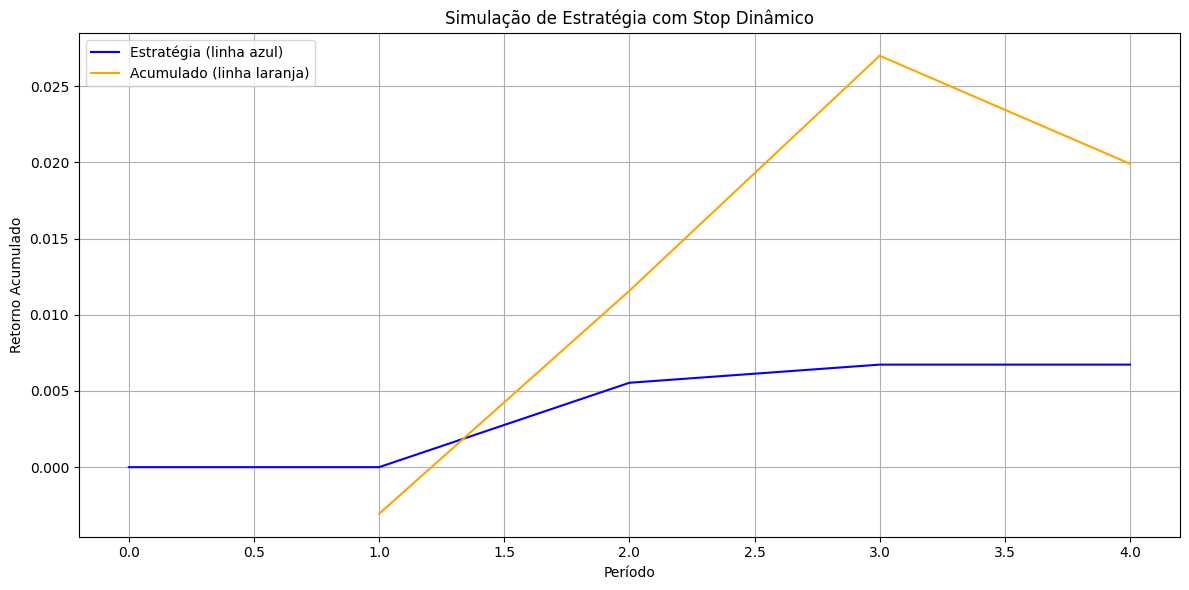

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Simulação de dados (insira mais se quiser simular mais períodos)
dados = [
    {"simbolo": "IVVB11USDT", "ultimo_preco": "349.83", "preco_minimo": "347.27", "preco_maximo": "351.36", "preco_abertura": "349.83", "datahora_fechamento": "2025-01-01T00:00:00Z"},
    {"simbolo": "IVVB11USDT", "ultimo_preco": "348.57", "preco_minimo": "347.20", "preco_maximo": "351.20", "preco_abertura": "348.57", "datahora_fechamento": "2025-01-02T00:00:00Z"},
    {"simbolo": "IVVB11USDT", "ultimo_preco": "354.59", "preco_minimo": "350.50", "preco_maximo": "358.00", "preco_abertura": "354.59", "datahora_fechamento": "2025-01-03T00:00:00Z"},
    {"simbolo": "IVVB11USDT", "ultimo_preco": "360.95", "preco_minimo": "355.01", "preco_maximo": "360.95", "preco_abertura": "360.95", "datahora_fechamento": "2025-01-04T00:00:00Z"},
    {"simbolo": "IVVB11USDT", "ultimo_preco": "358.02", "preco_minimo": "358.02", "preco_maximo": "360.67", "preco_abertura": "358.02", "datahora_fechamento": "2025-01-05T00:00:00Z"},
]

# Criar DataFrame
df = pd.DataFrame(dados)
df['datahora_fechamento'] = pd.to_datetime(df['datahora_fechamento'])
df = df.sort_values('datahora_fechamento').reset_index(drop=True)

# Converter colunas para float
for col in ['ultimo_preco', 'preco_minimo', 'preco_maximo', 'preco_abertura']:
    df[col] = df[col].astype(float)

# Coluna F - variação ajustada
df['var'] = ((df['ultimo_preco'] / df['ultimo_preco'].shift(1)) - 1) * 0.85

# Coluna G - acumulado
df['acumulado'] = ((1 + df['var']).cumprod()) - 1

# Coluna H - max-desceu
df['max_desceu'] = (df['preco_minimo'] / df['ultimo_preco'].shift(1)) - 1

# Coluna I - stop
df['stop'] = df.apply(lambda row: 0 if row['var'] < 0 else -row['max_desceu'], axis=1)

# Colunas J e K - retorno-estratégia e acumulado-estratégia
retornos = []
acumulado_estrategia = []
acum = 1

for i in range(len(df)):
    if i == 0:
        retornos.append(0)
        acumulado_estrategia.append(0)
        continue

    abertura = df.at[i, 'preco_abertura']
    fechamento = df.at[i, 'ultimo_preco']
    minimo = df.at[i, 'preco_minimo']
    stop_pct = df.at[i, 'stop']
    stop_preco = abertura * (1 - stop_pct)

    if minimo <= stop_preco:
        retorno = (stop_preco - abertura) / abertura
    else:
        retorno = (fechamento - abertura) / abertura

    retornos.append(retorno)
    acum *= (1 + retorno)
    acumulado_estrategia.append(acum - 1)

df['retorno_estrategia'] = retornos
df['acumulado_estrategia'] = acumulado_estrategia

# Plotando o gráfico
plt.figure(figsize=(12, 6))
plt.plot(df['acumulado_estrategia'], label='Estratégia (linha azul)', color='blue')
plt.plot(df['acumulado'], label='Acumulado (linha laranja)', color='orange')
plt.title('Simulação de Estratégia com Stop Dinâmico')
plt.xlabel('Período')
plt.ylabel('Retorno Acumulado')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
